In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tabulate import tabulate
from skimage.transform import resize
from monai.transforms import Resize
from models.unet_multidim import BasicUNet

from scripts.run_test import get_overlay
from utils.tools import load_checkpoint, mask_to_bbox_volumetric
from data.multidim_multilabel_dataset import Image_Dataset
from preprocessing.organ_labels_v2_volumetric import selected_organ_labels

/home/eytan/miniconda3/envs/label/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
test_data_file_path = '/home/eytan/storage/staff/eytankats/data/nako_10k/masks_projection_v2/test_masks_filtered_info.csv'
images_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/images_depth/'
masks_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/masks_aggregated_v2/'
masks_pattern = '/home/eytan/storage/staff/eytankats/data/nako_10k/masks_aggregated_v2/*.nii.gz'
labels_file = '/home/eytan/storage/staff/eytankats/data/nako_10k/labels_aggregated_v2.json'
ckpt_path = '/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202506161440_multidim_multilabel_unet_aggmasksv2/checkpoints/best_valid_loss.pth'

In [21]:
df = pd.read_csv('/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202505141433_multilabel_basicunet_filteredaggmasksv2/results.csv')[:-2]
# df['experiment'] = 'multilabel_basicunet_filteredaggmasksv2'

In [22]:
def prepare_long_format(df, prefixes):
    rows = []
    for col in df.columns:
        for p in prefixes:
            if col.startswith(p + '_'):
                suffix = col[len(p) + 1:]

                rows.append({
                    'prefix': p,
                    'suffix': suffix,
                    'value': df[col],
                    # 'experiment': df['experiment']
                })
                break  # once matched, no need to check other prefixes
    long_df = pd.concat([
        pd.DataFrame({
            'prefix': row['prefix'],
            'suffix': row['suffix'],
            'value': row['value'],
            # 'experiment': row['experiment']
        }) for row in rows
    ], ignore_index=True)
    return long_df

def plot_grouped_by_prefix(df, prefixes, title, aspect_ratio=2.5, outliers=False):
    long_df = prepare_long_format(df, prefixes)

    sns.set_theme(style="whitegrid")
    g = sns.catplot(
        kind='box',
        data=long_df,
        x='suffix',
        y='value',
        hue='prefix',
        # col='experiment',  # if you want each experiment in its own subplot
        height=6,
        aspect=aspect_ratio,
        # legend=True,
        whis=(5, 95),
        width=.75,
        showfliers=outliers
    )

    g.set(xlabel='', ylabel='detection offset error (mm)', title=title)
    g.set_xticklabels(rotation=90)

    # g.add_legend(title='bbox')
    g._legend.set_bbox_to_anchor((1.1, 1))  # Right outside top corner
    # g._legend.set_loc('upper left')

    plt.tight_layout()

In [23]:
print(tabulate(df.tail(10), headers='keys', tablefmt='psql'))

+-----+------------+-------------+--------------+-----------------+-----------------+---------------+----------------+-------------------+-------------------+---------------------+----------------------+-------------------------+-------------------------+--------------------+---------------------+------------------------+------------------------+--------------+---------------+------------------+------------------+----------------+-----------------+--------------------+--------------------+-----------------+------------------+---------------------+---------------------+-----------------------------+------------------------------+---------------------------------+---------------------------------+-----------------------------+------------------------------+---------------------------------+---------------------------------+------------------------------+-------------------------------+----------------------------------+----------------------------------+-------------------------------+--

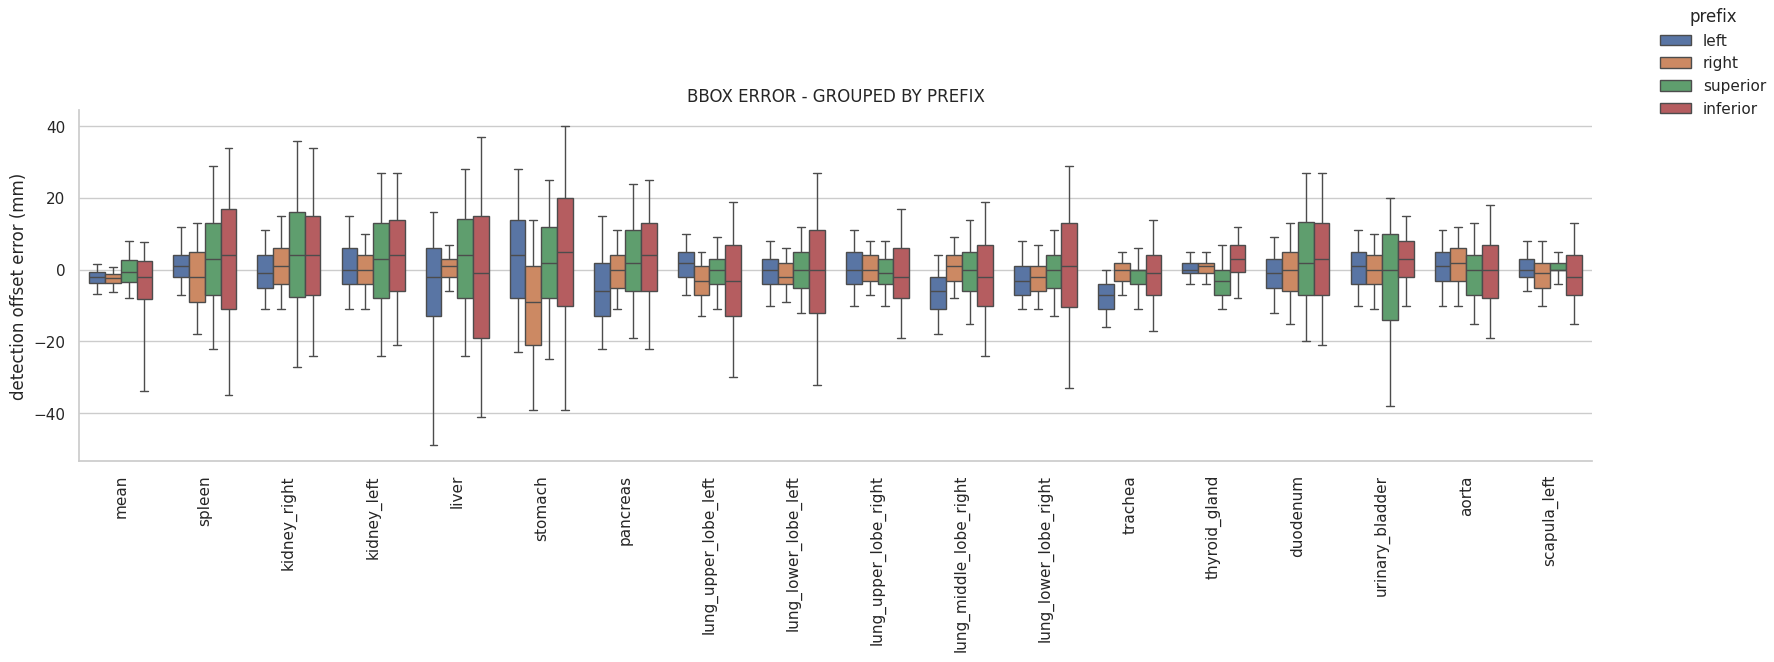

In [29]:
prefixes = ['left', 'right', 'inferior', 'superior', 'anterior', 'posterior']
plot_grouped_by_prefix(df.iloc[:, :73], prefixes, title="BBOX ERROR - GROUPED BY PREFIX")

In [7]:
# Initialize dataset and model
test_dataset = Image_Dataset(test_data_file_path, images_dir=images_dir, masks_pattern=masks_pattern, labels_file=labels_file, stage='test')

model = BasicUNet(in_channels=3, out_channels=len(selected_organ_labels) + 1, dropout=False)
model = load_checkpoint(model, ckpt_path)

BasicUNet features: (64, 64, 128, 256, 512).
BasicUNet features: (16, 16, 32, 64, 128, 16).


In [11]:
def visualize_results(sample, anatomy):

    anatomy_idx = selected_organ_labels.index(anatomy)
    data_idx = test_dataset.name_list.index(sample)
    data = test_dataset[data_idx]

    img_rgb = data['img'].unsqueeze(0)

    if (img_rgb == 0).all():
        return

    img_rgb = img_rgb / 255.0
    img_rgb = 2. * img_rgb - 1.

    seg_img = torch.stack(data['seg'], dim=1).float()
    seg_img = seg_img.unsqueeze(1).float()

    with torch.no_grad():
        pred_seg = torch.nn.functional.sigmoid(model(img_rgb))

    gt_resize_transform = Resize(spatial_size=(390, 480, 948), mode='nearest')
    pred_resize_transform = Resize(spatial_size=(390, 480, 948))

    seg_anatomy = torch.zeros_like(seg_img)
    seg_anatomy[seg_img == anatomy_idx + 1] = 1
    seg_anatomy = seg_anatomy.squeeze()

    pred_anatomy = pred_seg[0, anatomy_idx + 1, :, :, :]

    seg_anatomy = gt_resize_transform(seg_anatomy.unsqueeze(0)).squeeze().numpy()
    pred_anatomy = pred_resize_transform(pred_anatomy.unsqueeze(0)).squeeze().detach().cpu().numpy()
    # pred_anatomy = pred_resize_transform(pred_anatomy.unsqueeze(0)).squeeze().detach().cpu().numpy()

    bbox_seg = mask_to_bbox_volumetric(seg_anatomy)
    bbox_pred = mask_to_bbox_volumetric(np.uint8(pred_anatomy > 0.5))

    # if bbox_seg is not None and bbox_pred is not None:
    #     inferior_anatomy = bbox_seg['x1'] - bbox_pred['x1']
    #     right_anatomy = bbox_seg['y1'] - bbox_pred['y1']
    #     superior_anatomy = bbox_pred['x2'] - bbox_seg['x2']
    #     left_anatomy = bbox_pred['y2'] - bbox_seg['y2']
    #     anterior_anatomy = bbox_seg['z1'] - bbox_pred['z1']
    #     posterior_anatomy = bbox_pred['z2'] - bbox_seg['z2']
    # else:
    #     left_anatomy = np.nan
    #     right_anatomy = np.nan
    #     superior_anatomy = np.nan
    #     inferior_anatomy = np.nan
    #     anterior_anatomy = np.nan
    #     posterior_anatomy = np.nan
    #
    # bbox_seg = mask_to_bbox_v2(np.rot90(seg_anatomy))
    # bbox_pred = mask_to_bbox_v2(np.uint8(np.rot90(pred_anatomy) > 0.5))
    #
    # img_to_plot = np.uint8(np.rot90(resize((img_rgb[0].permute(1, 2, 0).cpu().detach().numpy() + 1) / 2, (480, 948), order=1, mode='constant')) * 255)
    # seg_to_plot = np.uint8(np.rot90(seg_anatomy) * 255)
    # pred_to_plot_thr = np.uint8(np.rot90(pred_anatomy_thr) * 255)
    #
    # overlay_to_plot = np.uint8(get_overlay(img_to_plot, seg_to_plot, np.zeros_like(seg_to_plot)))
    # overlay_to_plot_thr = np.uint8(get_overlay(img_to_plot, seg_to_plot, pred_to_plot_thr))
    #
    # seg_to_plot_rgb = np.zeros_like(img_to_plot)
    # seg_to_plot_rgb[:, :, 0] = seg_to_plot
    # seg_to_plot_rgb[:, :, 1] = seg_to_plot
    # seg_to_plot_rgb[:, :, 2] = seg_to_plot
    #
    # # Image with predicted bbox drawn
    # img_with_pred_bbox = overlay_to_plot.copy()
    # if bbox_pred is not None:
    #     cv2.rectangle(img_with_pred_bbox, (bbox_pred['x1'], bbox_pred['y1']), (bbox_pred['x2'], bbox_pred['y2']), (0, 255, 0), 3)
    # if bbox_seg is not None:
    #     cv2.rectangle(img_with_pred_bbox, (bbox_seg['x1'], bbox_seg['y1']), (bbox_seg['x2'], bbox_seg['y2']), (255, 0, 0), 3)
    #
    # stacked_img = np.concatenate((img_to_plot, seg_to_plot_rgb, overlay_to_plot_thr, img_with_pred_bbox), axis=1)
    #
    # plt.figure(figsize=(8, 15))
    # plt.imshow(stacked_img)
    # plt.grid(False)
    # plt.title(f'left: {left_anatomy}\nright: {right_anatomy}\nsuperior: {superior_anatomy}\ninferior: {posterior_anatomy}')